In [1]:
import re
import os
import warnings
from math import floor
from itertools import product

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning


from sklearn.manifold import TSNE

In [2]:
strategies = ['None', 'Specific', 'Generic']
temperatures = ['0.0', '0.7']
variations = ['0', '1', '2']
recursions = ['0', '1']

# Pattern for extracting features
regex_patterns = {
    'Powderkg': r'Powderkg = (\d+)',
    'wc': r'wc = ([\d.]+)',
    'materials': r'materials = ([\d./]+)',
    'curing': r'curing = (.+?)(?:\n|$)'
}

def extract_data_for_given_run(pattern):
    """
    :param pattern: Pattern of filenames holding results of experimental runs
    :return: Dataframe with all results for the given filename pattern
    """
    matching_filenames = []
    # Iterate through the files in the directory
    dir_name = 'Results/ID'
    for filename in os.listdir(dir_name):
        match = re.match(pattern, filename)
        if match:
            matching_filenames.append(os.path.join(dir_name, filename))
    all_results_df = pd.DataFrame()
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
    for i, filename in enumerate(matching_filenames):
        results_sample_df = pd.read_csv(filename)
        for col, pattern in regex_patterns.items():
            all_results_df[f'{col} {i}'] = results_sample_df['Formulation'].str.extract(pattern, expand=False)
            if col.startswith('materials'):
                all_results_df[f'{col} {i}'] = all_results_df[f'{col} {i}'].str[:3]
            if col.startswith('curing'):
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('Heat')] = 0
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('heat')] = 0
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('Ambient')] = 1
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('ambient')] = 1
            all_results_df[f'{col} {i}'] = all_results_df[f'{col} {i}'].astype(float)
    return all_results_df, matching_filenames

pattern = fr'gpt-3.5-turbo_None 0_prompt_experiment_(\d+)_temp_0.0_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_0_(\d+)\.csv'
extract_data_for_given_run(pattern)

(   Powderkg 0  wc 0  materials 0  curing 0  Powderkg 1  wc 1  materials 1  \
 0       360.0  0.45          0.7       1.0       360.0  0.45          0.7   
 1       450.0  0.60          0.5       0.0       450.0  0.60          0.5   
 2       410.0  0.55          0.6       0.0       410.0  0.55          0.6   
 3       430.0  0.50          0.7       0.0       430.0  0.50          0.7   
 4       380.0  0.60          0.5       1.0       380.0  0.60          0.5   
 5       400.0  0.55          0.6       1.0       400.0  0.55          0.6   
 6       390.0  0.50          0.7       0.0       390.0  0.50          0.7   
 7       440.0  0.45          0.6       1.0       440.0  0.45          0.6   
 8       450.0  0.60          0.7       1.0       450.0  0.60          0.7   
 9       420.0  0.50          0.6       0.0       420.0  0.55          0.5   
 
    curing 1  Powderkg 2  wc 2  materials 2  curing 2  Powderkg 3  wc 3  \
 0       1.0       360.0  0.45          0.7       1.0       360.0

In [3]:
all_combinations = list(product(strategies, temperatures, recursions))

def compute_std_over_different_runs(df, number_of_iterations=10):
    df = df.copy()
    std_for_each_run = []
    for i in range(number_of_iterations):
        df[i] = df[i].fillna(df[i].mean())
        max = df[i].max()
        min = df[i].min()
        if max - min == 0:
            std = df[i].std()
        else:
            std = df[i].std() / (max - min)
        std_for_each_run.append(std)
    return np.array(std_for_each_run)


def normalize_feature(feature):
    max = feature.max()
    if max == 0:
        max = 1
    return feature / max


def get_max(df):
    max = np.max(df)
    if max == 0:
        max = 1
    return max


def find_matching_files(patterns):
    filenames = []

    dir_name = 'Results/ID'
    for filename in os.listdir(dir_name):
        for pattern in patterns:
            match = re.match(pattern, filename)
            if match:
                filenames.append(os.path.join(dir_name, filename))
    return filenames


def extract_data_for_given_run_for_all_variations(patterns):
    all_filenames = find_matching_files(patterns)

    all_runs_df = pd.DataFrame()
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
    for i, filename in enumerate(all_filenames):
        results_sample_df = pd.read_csv(filename)

        for col, pattern in regex_patterns.items():
            all_runs_df[f'{col} {i}'] = results_sample_df['Formulation'].str.extract(pattern, flags=re.DOTALL,
                                                                                     expand=False)
            if col.startswith('materials'):
                all_runs_df[f'{col} {i}'] = all_runs_df[f'{col} {i}'].str[:3]
            if col.startswith('curing'):
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('Heat')] = 0
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('heat')] = 0
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('Ambient')] = 1
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('ambient')] = 1

    return all_runs_df, all_filenames


def count_unique_tsne_points(tsne_result):
    precision = 2  # Adjust this based on your data and desired precision
    rounded_coordinates = np.round(tsne_result, precision)

    coordinate_tuples = [tuple(coord) for coord in rounded_coordinates]

    unique = {coord: coordinate_tuples.count(coord) for coord in set(coordinate_tuples)}

    return len(unique.items())


def compute_avg_dist(result, top_result):
    distances = []
    for vector in result:
        distances.append(np.linalg.norm(vector - top_result))
    return np.round(np.mean(distances), 2)


def compute_min_distance(result, threshold_recipes):
    distances = []
    threshold_recipes = threshold_recipes.values
    for vector in result:
        distances_to_top = []
        for top in threshold_recipes:
            dist = np.linalg.norm(vector - top)
            distances_to_top.append(dist)
        distances.append(min(distances_to_top))
    return np.round(np.min(distances), 2)


def compute_max_distance(result, top_result):
    distances = []
    for vector in result:
        distances.append(np.linalg.norm(vector - top_result))
    return np.round(np.max(distances), 2)


def compute_avg_grad(vector):
    diffs = np.array([])
    for i in range(len(vector)):
        if i < len(vector) - 1:
            grad = vector[i + 1] - vector[i]
            diffs = np.append(diffs, grad)
    return np.round(np.mean(diffs), 2)


def get_material_dfs_from_all_results_df(matching_filenames, all_results_df):
    features = ['Powderkg', 'wc', 'materials', 'curing']
    powders = {}
    wc_ratios = {}
    materials = {}
    curing = {}

    for feature in features:
        for i in range(len(matching_filenames)):
            if feature == 'Powderkg':
                powders[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)
            elif feature == 'wc':
                wc_ratios[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)
            elif feature == 'materials':
                materials[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)
            elif feature == 'curing':
                curing[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)

    return pd.DataFrame(powders).T, pd.DataFrame(wc_ratios).T, pd.DataFrame(materials).T, pd.DataFrame(curing).T


def add_current_iteration_results_to_recipe_vectors(recipes_df, materials_df, iter):
    powders = materials_df.feature_dfs[0]
    wc = materials_df.feature_dfs[1]
    materials = materials_df.feature_dfs[2]
    curing = materials_df.feature_dfs[3]

    powders[iter] = powders[iter].fillna(powders[iter].mean())
    wc[iter] = wc[iter].fillna(wc[iter].mean())
    materials[iter] = materials[iter].fillna(materials[iter].mean())
    curing[iter] = curing[iter].fillna(curing[iter].mean())

    iter_df = pd.DataFrame(
        {
            'powders': powders[iter].values / materials_df.max_values[0],
            'wc': wc[iter].values / materials_df.max_values[1],
            'materials': materials[iter].values / materials_df.max_values[2],
            'curing': curing[iter].values / materials_df.max_values[3]
        }
    )

    return pd.concat([recipes_df, iter_df])


def create_normalized_recipe_vectors(materials_df, nr_iter):
    recipes = pd.DataFrame(columns=[])
    for iteration in range(nr_iter):
        recipes = add_current_iteration_results_to_recipe_vectors(recipes, materials_df, iteration)
    return recipes


def find_top_recipes(max_values, with_threshold=True):
    # threshold from Inverse Design Results.ipynb
    threshold = 64.86370000000001
    top = pd.read_csv('Data/Top4.csv',
                      usecols=['powders', 'wc', 'materials', 'curing', 'fc_28d'],
                      dtype={
                          'powders': float,
                          'wc': float,
                          'materials': float,
                          'curing': float,
                          'fc_28d': float
                      })
    if with_threshold:
        top = top[top['fc_28d'] > threshold]
    top = top[['powders', 'wc', 'materials', 'curing']]
    top['powders'] = top['powders'] / max_values[0]
    top['wc'] = top['wc'] / max_values[1]
    top['materials'] = top['materials'] / max_values[2]
    top['curing'] = top['curing'] / max_values[3]

    return top

def get_design_space(target_mode):
    df = pd.read_csv('Data/DiscoveryData_Sample.csv')

    formulation_df = pd.DataFrame(columns=['powders', 'wc', 'materials', 'curing', 'strength'])

    # Loop through each row in the original data
    for idx, row in df.iterrows():
        powder = row['Powderkg']
        wc = row['WC']
        materials = row['Materials']

        fa_ggbfs = float(materials.split(",")[0].split("-")[1][:3])
        curing_method = materials.split(",")[-1].strip()

        strength = row['fc_28dGroundTruth']

        # Remove unwanted string from curing method
        curing_method = curing_method.replace(" (Rao et al. 2018)", "")
        curing_method = curing_method.replace(" (Rao et al.)", "").lower()
        curing_method = 0 if curing_method.startswith('heat') else 1

        # Compressive strength
        formulation_df.loc[idx, 'powders'] = powder
        formulation_df.loc[idx, 'wc'] = wc
        formulation_df.loc[idx, 'materials'] = fa_ggbfs
        formulation_df.loc[idx, 'curing'] = curing_method
        formulation_df.loc[idx, 'strength'] = strength

    if target_mode:
        formulation_df = formulation_df.sort_values(by=['strength'], ascending=False)

    return formulation_df

def normalize_design_space(design_space, max_values):
    design_space['powders'] = design_space['powders'] / max_values[0]
    design_space['wc'] = design_space['wc'] / max_values[1]
    design_space['materials'] = design_space['materials'] / max_values[2]
    design_space['curing'] = design_space['curing'] / max_values[3]
    return design_space

# TODO: Clean up
def plot_recipes_in_2d(tsne_data,
                       original_recipes,
                       threshold_recipes,
                       nr_of_recipes_total,
                       nr_of_top_recipes,
                       nr_of_runs_per_conf,
                       model,
                       strategy,
                       temperature,
                       recursion,
                       targets):
    top_tsne_result = tsne_data[len(tsne_data) - nr_of_top_recipes:len(tsne_data)]

    threshold_recipe = threshold_recipes.iloc[len(threshold_recipes) - 1]


    color_idx = 0
    avg_distances = []
    min_distances = []
    max_distances = []

    colors = targets
    cmap = matplotlib.colormaps['Oranges']

    plt.figure(figsize=(12, 9))
    # The first subset represents the full design space
    ds = plt.scatter(tsne_data[:nr_of_recipes_total, 0], tsne_data[:nr_of_recipes_total, 1],
                    s=20,
                    c=colors,
                    cmap=cmap)

    cbar = plt.colorbar(ds)
    cbar.set_label('FC 28 d Ground Truth')

    colors = [
        '#0000FF',  # Blue
        '#0000CC',
        '#000099',
        '#000066',
        '#3366FF',
        '#3399FF',
        '#33CCFF',
        '#33FFFF',
        '#66FFCC',
        '#00FF00'   # Green
    ]

    # The second subset are the top 3 recipes
    plt.scatter(top_tsne_result[0, 0], top_tsne_result[0, 1], marker='x', color='red', s=150)
    plt.scatter(top_tsne_result[1:, 0], top_tsne_result[1:, 1], marker='x', color='red', s=150,
                label=f'Top Recipes')

    # The final subset are the proposals of the LLM over all runs at each iteration
    for i in range(nr_of_recipes_total, len(tsne_data) - nr_of_top_recipes, nr_of_runs_per_conf):
        subset_tsne_result = tsne_data[i:i + nr_of_runs_per_conf]

        # Count occurrences of each unique combination of t-SNE coordinates
        tmp = pd.DataFrame(subset_tsne_result)
        occurrences = tmp.round(decimals=2).value_counts().values
        unique_count = count_unique_tsne_points(subset_tsne_result)

        subset_original_recipes = original_recipes[i:i + nr_of_runs_per_conf].values
        avg_dist = compute_avg_dist(subset_original_recipes, threshold_recipe.values)
        min_distance = compute_min_distance(subset_original_recipes, threshold_recipes)
        max_distance = compute_max_distance(subset_original_recipes, threshold_recipe.values)

        avg_distances.append(avg_dist)
        min_distances.append(min_distance)
        max_distances.append(max_distance)

        tmp = tmp.round(decimals=2).drop_duplicates()
        subset_tsne_result = tmp.values
        for row in range(subset_tsne_result.shape[0]):
            if row == subset_tsne_result.shape[0] - 1:
                plt.scatter(subset_tsne_result[row, 0], subset_tsne_result[row, 1],
                            s=occurrences[row]**(3/2) * 8,
                            color=colors[color_idx],
                            marker='D',
                            alpha=0.5,
                            label=f'Iter. {(i - nr_of_recipes_total) // nr_of_runs_per_conf + 1} (Mean dist. {avg_dist}, Min dist. {min_distance})')
            else:
                plt.scatter(subset_tsne_result[row, 0], subset_tsne_result[row, 1],
                            s=occurrences[row]**(3/2) * 8,
                            color=colors[color_idx],
                            marker='D',
                            alpha=0.5,
                            label=None)
        color_idx += 1

    plt.xlabel('TSNE - x')
    plt.ylabel('TSNE - y')

    max_x = np.max(tsne_data[:, 0])
    min_x = np.min(tsne_data[:, 0])
    max_y = np.max(tsne_data[:, 1])
    min_y = np.min(tsne_data[:, 1])

    lim_x = np.abs(max_x) if np.abs(max_x) > np.abs(min_x) else np.abs(min_x)
    lim_y = np.abs(max_y) if np.abs(max_y) > np.abs(min_y) else np.abs(min_y)

    x_axis = list(range(- floor(min_x) - 10, floor(max_x) + 10))
    x_axis = [tick for tick in x_axis if tick % 5 == 0]
    y_axis = list(range(- floor(max_y) - 10, floor(max_y) + 10))
    y_axis = [tick for tick in y_axis if tick % 10 == 0]
    plt.xticks(rotation=45)
    # plt.yticks()
    lgd =plt.legend(handlelength=2, handleheight=2)
    for handle in lgd.legend_handles:
        handle.set_sizes([30.0])
    if recursion == '1':
        tt = 'Increased TT'
    else:
        tt = 'Baseline'
    plt.title(f'Model: {model}, Information Quality {strategy}, Temperature {temperature}, Strategy {tt}')
    # plt.show()
    plt.savefig(f'Results/Recipe_Distribution_Analysis/TSNE with Design Space and Predictions for Model {model} Strategy {strategy} Temperature {temperature} Recursion {recursion}.png', bbox_inches='tight')


def set_dist_to_best_so_far(distances):
    for i in range(1, len(distances)):
        if distances[i] > distances[i - 1]:
            distances[i] = distances[i - 1]
    return distances


class MaterialsDataframes:

    def __init__(self, feature_dfs, max_values):
        self.feature_dfs = feature_dfs
        self.max_values = max_values


def plot_recipes_with_strength_indication(tsne_data,
                                          nr_of_recipes_total,
                                          nr_of_top_recipes,
                                          targets):
    top_tsne_result = tsne_data[len(tsne_data) - nr_of_top_recipes:len(tsne_data)]

    colors = targets

    cmap = matplotlib.colormaps['viridis']
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_data[:nr_of_recipes_total, 0], tsne_data[:nr_of_recipes_total, 1],
                s=10,
                c=colors,
                cmap=cmap)

    plt.scatter(top_tsne_result[-1, 0], top_tsne_result[-1, 1], marker='x', color='red', s=50)

    plt.xlabel('TSNE - x')
    plt.ylabel('TSNE - y')

    max_x = np.max(tsne_data[:, 0])
    min_x = np.min(tsne_data[:, 0])
    max_y = np.max(tsne_data[:, 1])
    min_y = np.min(tsne_data[:, 1])

    lim_x = np.abs(max_x) if np.abs(max_x) > np.abs(min_x) else np.abs(min_x)
    lim_y = np.abs(max_y) if np.abs(max_y) > np.abs(min_y) else np.abs(min_y)

    x_axis = list(range(- floor(lim_x) - 10, floor(lim_x) + 10))
    x_axis = [tick for tick in x_axis if tick % 10 == 0]
    y_axis = list(range(- floor(lim_y) - 10, floor(lim_y) + 10))
    y_axis = [tick for tick in y_axis if tick % 10 == 0]
    plt.xticks(x_axis, rotation=45)
    plt.yticks(y_axis)
    plt.title(f'Design Space wit Compressive Strengths')

    cbar = plt.colorbar(scatter)
    cbar.set_label('FC 28 d Ground Truth')

    plt.show()
    # plt.savefig(f'Results/Recipe_Distribution_Analysis/TSNE with all Recipes for Strategy {strategy} Temperature {temperature} Recursion {recursion}.png', bbox_inches='tight')



#### Main Function

In [4]:
# TODO: Clean up
def analyse_distribution(tsne_model, target_mode=True, model='gpt-3.5-turbo'):
    configs_with_less_than_ten_iterations = 0

    for combination in all_combinations:
        strategy = combination[0]
        temperature = combination[1]
        recursion = combination[2]

        # We did not implement Increased TT with gpt-4
        if model == 'gpt-4-1106-preview' and recursion == '1':
            print('SKIP THIS ITERATION')
            continue

        print(f'####### Run with strategy {strategy}, temperature {temperature} and recursion {recursion} #########')

        pattern_0 = fr'{model}_{strategy} 0_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'
        pattern_1 = fr'{model}_{strategy} 1_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'
        pattern_2 = fr'{model}_{strategy} 2_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'

        patterns = [pattern_0, pattern_1, pattern_2]

        all_results_df, matching_filenames = extract_data_for_given_run_for_all_variations(patterns)

        # TODO: properly handle this case
        number_of_iterations = len(all_results_df)
        expected_nr_iter = 10 if model == 'gpt-3.5-turbo' else 5
        if not matching_filenames or number_of_iterations != expected_nr_iter:
            print(f'Warning: Some of the files for {strategy} {temperature} {recursion} have less than {expected_nr_iter} rows per dataframe')
            print(f'Nr. of iterations: {number_of_iterations}')
            configs_with_less_than_ten_iterations = configs_with_less_than_ten_iterations + 1

        warnings.filterwarnings("default")

        design_space = get_design_space(target_mode)

        df_powders, df_wc, df_materials, df_curing = get_material_dfs_from_all_results_df(matching_filenames, all_results_df)
        max_powders = get_max(design_space['powders'])
        max_wc = get_max(design_space['wc'])
        max_materials = get_max(design_space['materials'])
        max_curing = get_max(design_space['curing'])

        materials_df = MaterialsDataframes(feature_dfs=[df_powders, df_wc, df_materials, df_curing],
                                           max_values=[max_powders, max_wc, max_materials, max_curing])

        top_recipes = find_top_recipes(materials_df.max_values)

        design_space = normalize_design_space(design_space, materials_df.max_values)

        targets = design_space['strength']

        df_recipe_vectors = create_normalized_recipe_vectors(materials_df, df_powders.shape[1])

        all_recipes = design_space[['powders', 'wc', 'materials', 'curing']]

        df_recipe_vectors = pd.concat([all_recipes, df_recipe_vectors, top_recipes])
        df_recipe_vectors = df_recipe_vectors.dropna(axis=1)

        tsne_result = tsne_model.fit_transform(df_recipe_vectors.values)

        # normiere, so dass das beste Rezept im Zentrum dargestellt wird
        if not target_mode:
            tsne_result = tsne_result - tsne_result[-len(top_recipes)]
        else:
            tsne_result = tsne_result - tsne_result[0]

       # if not target_mode:
        plot_recipes_in_2d(tsne_result,
                           df_recipe_vectors,
                           top_recipes,
                           len(design_space),
                           len(top_recipes),
                           df_powders.shape[0],
                           model,
                           strategy,
                           temperature,
                           recursion,
                           targets)
        # else:
        #     plot_recipes_with_strength_indication(tsne_result,
        #                                           len(design_space),
        #                                           len(top_recipes),
        #                                           targets)

    print(f'####### Nr of warnings: {configs_with_less_than_ten_iterations} #######')

In [12]:
tsne_model = TSNE(n_components=2,
                  perplexity=50,
                  early_exaggeration=50,
                  learning_rate=50,
                  random_state=42,
                  n_iter=2000,
                  init='pca')

### TSNE with Suggestions by GPT

####### Run with strategy None, temperature 0.0 and recursion 0 #########
####### Run with strategy None, temperature 0.0 and recursion 1 #########
####### Run with strategy None, temperature 0.7 and recursion 0 #########
####### Run with strategy None, temperature 0.7 and recursion 1 #########
####### Run with strategy Specific, temperature 0.0 and recursion 0 #########
####### Run with strategy Specific, temperature 0.0 and recursion 1 #########
####### Run with strategy Specific, temperature 0.7 and recursion 0 #########
####### Run with strategy Specific, temperature 0.7 and recursion 1 #########
####### Run with strategy Generic, temperature 0.0 and recursion 0 #########
####### Run with strategy Generic, temperature 0.0 and recursion 1 #########
####### Run with strategy Generic, temperature 0.7 and recursion 0 #########
####### Run with strategy Generic, temperature 0.7 and recursion 1 #########
####### Nr of warnings: 0 #######


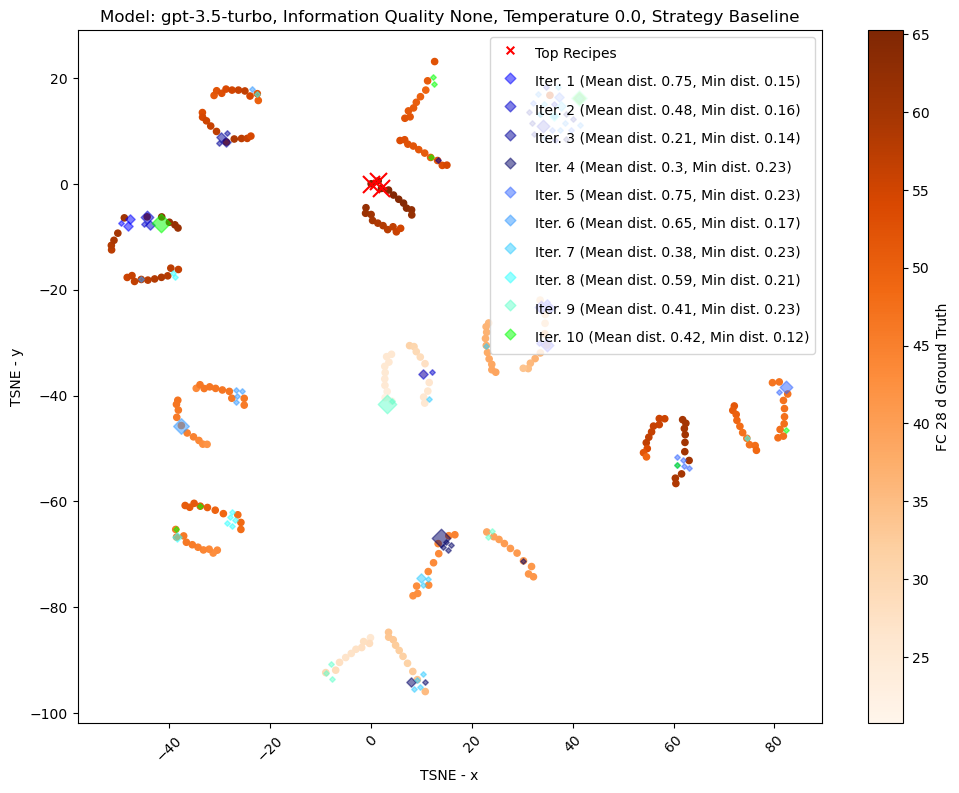

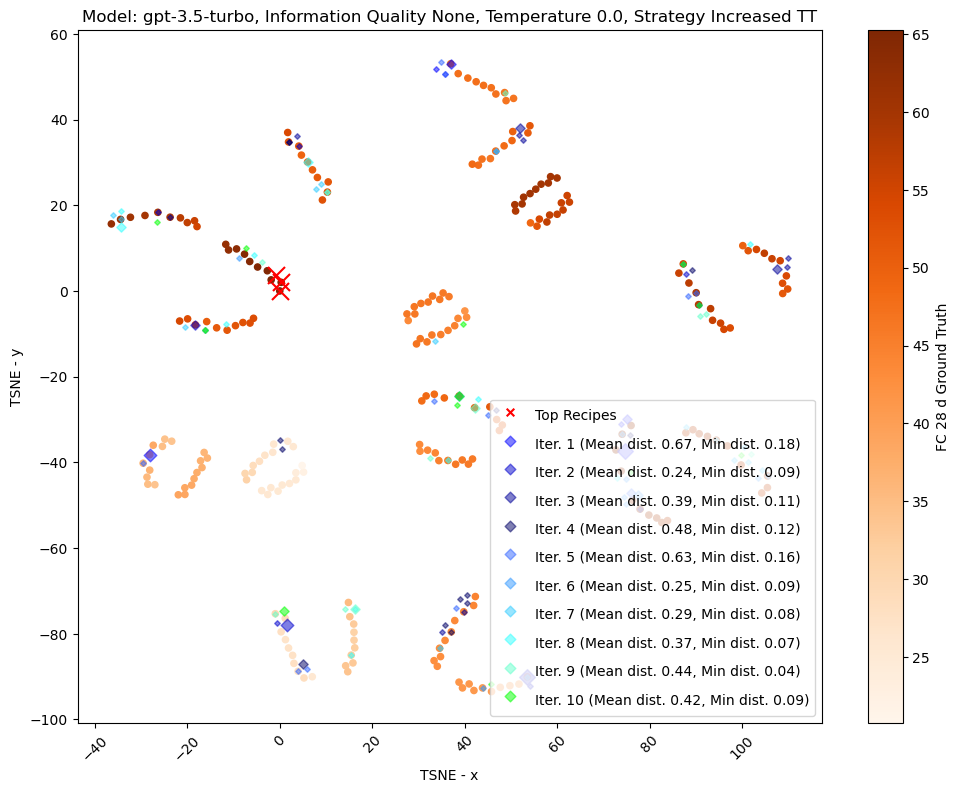

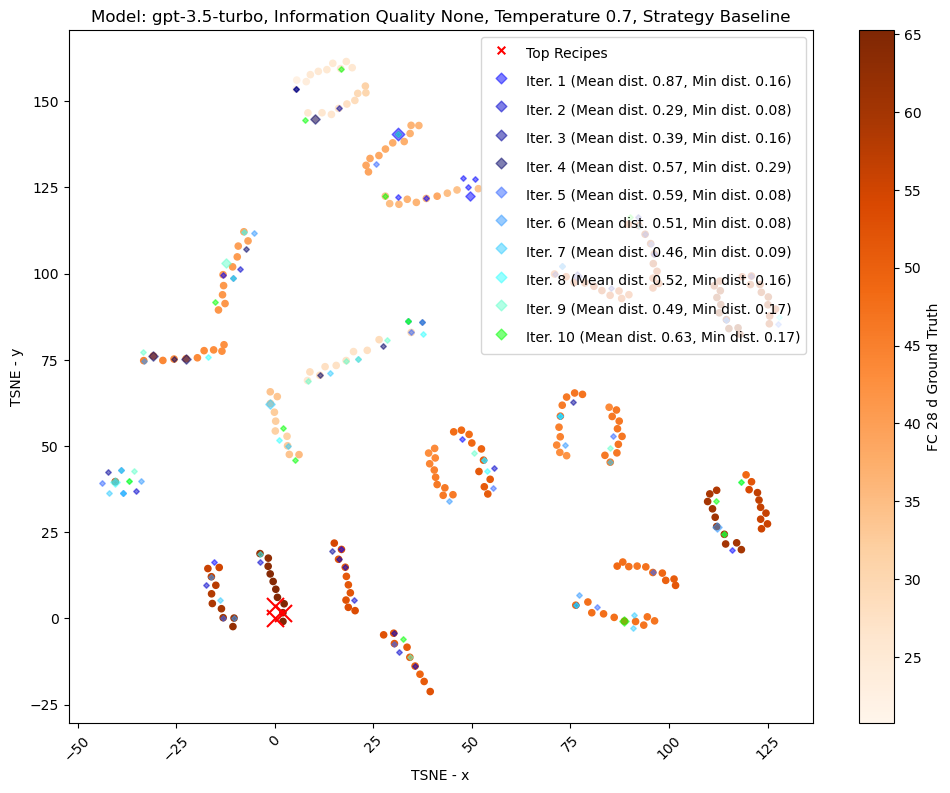

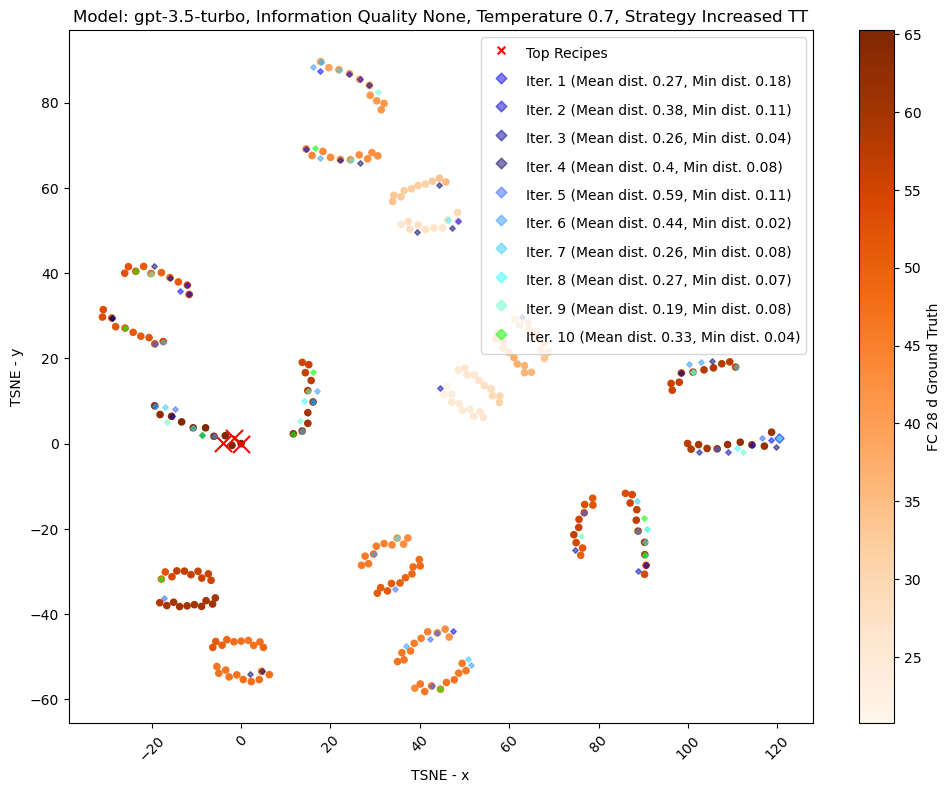

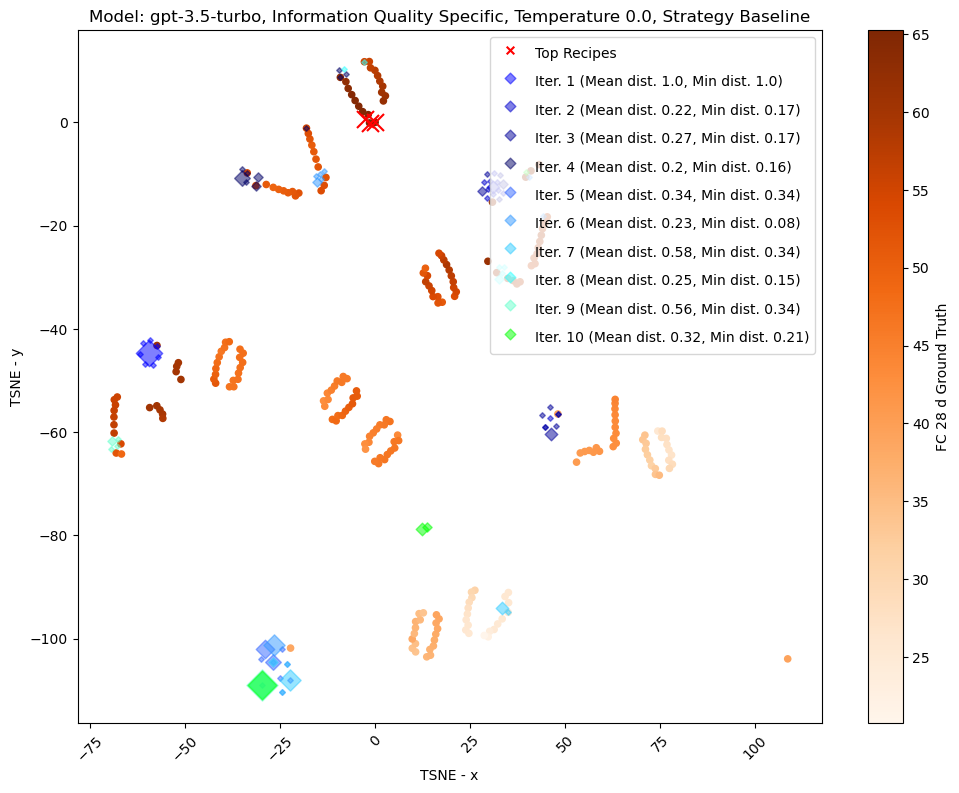

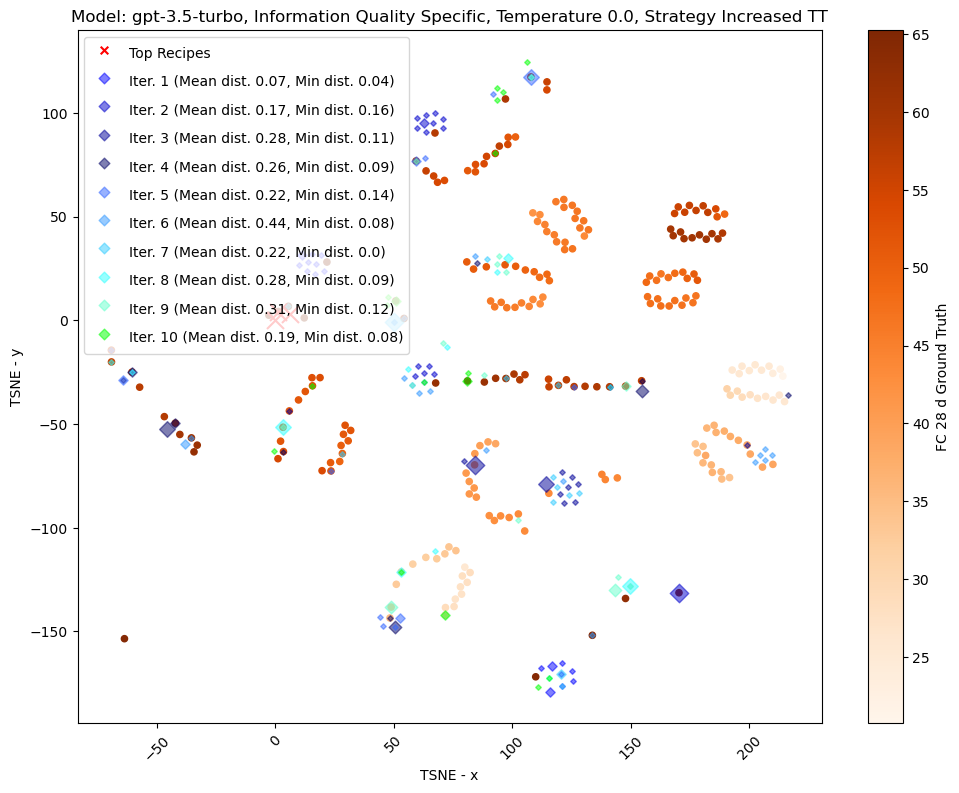

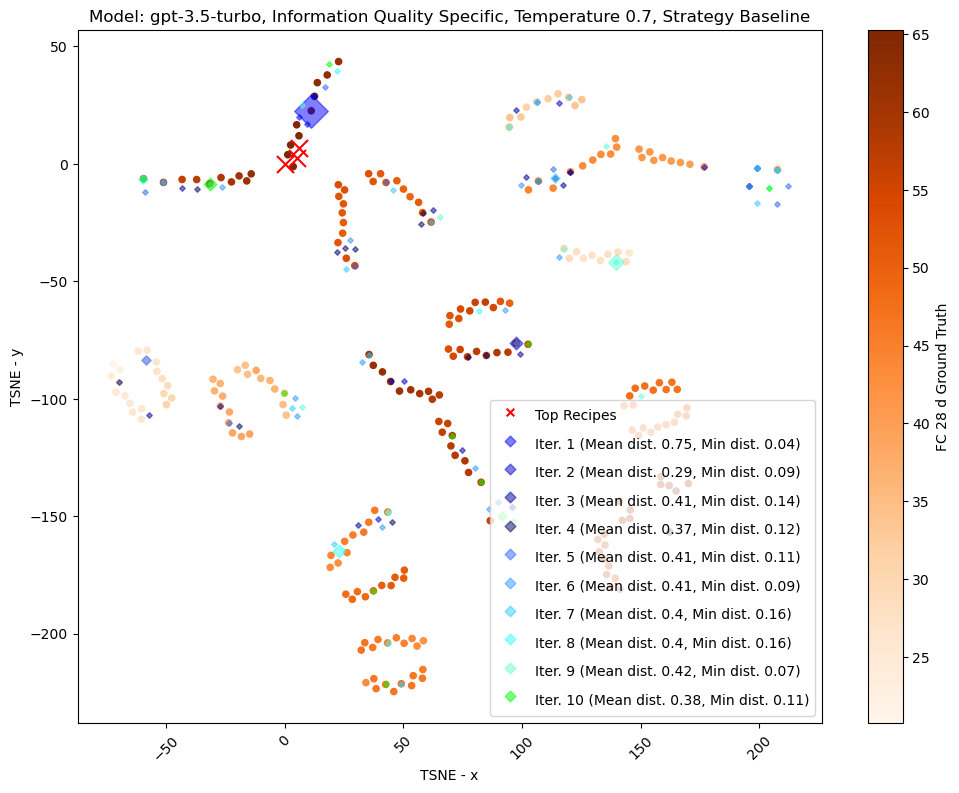

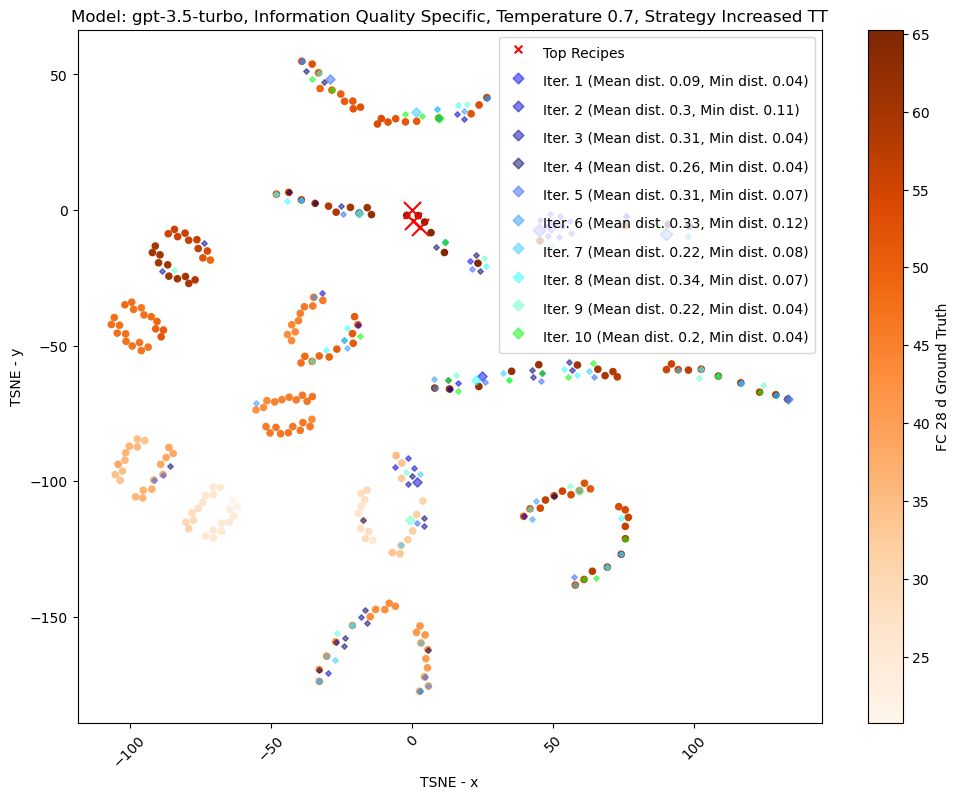

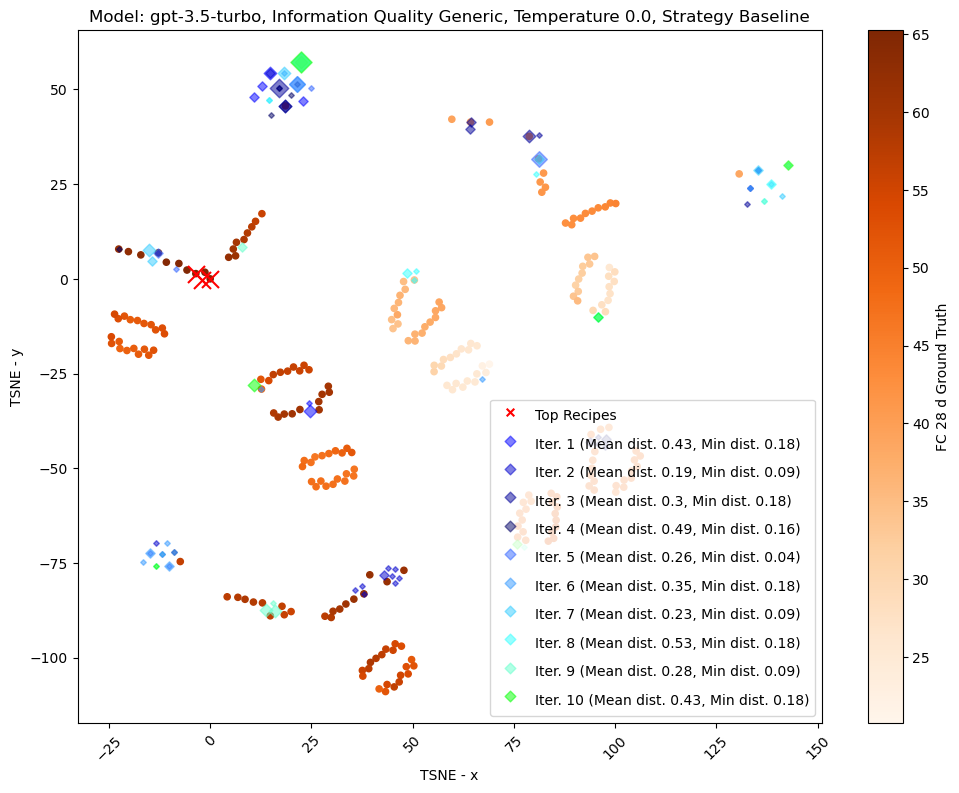

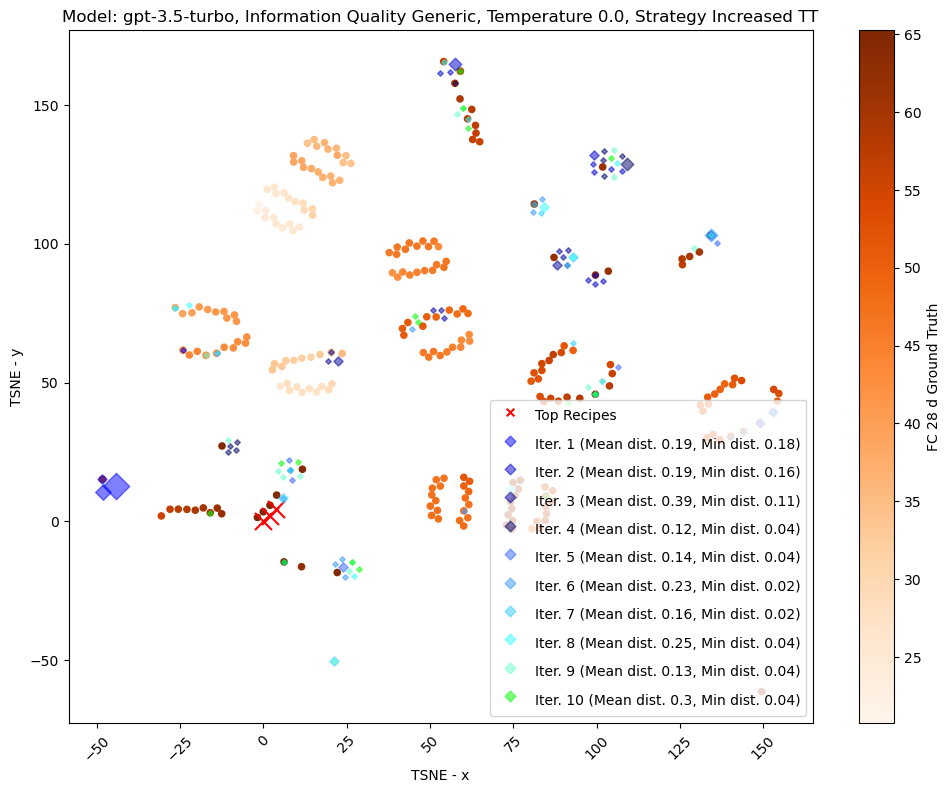

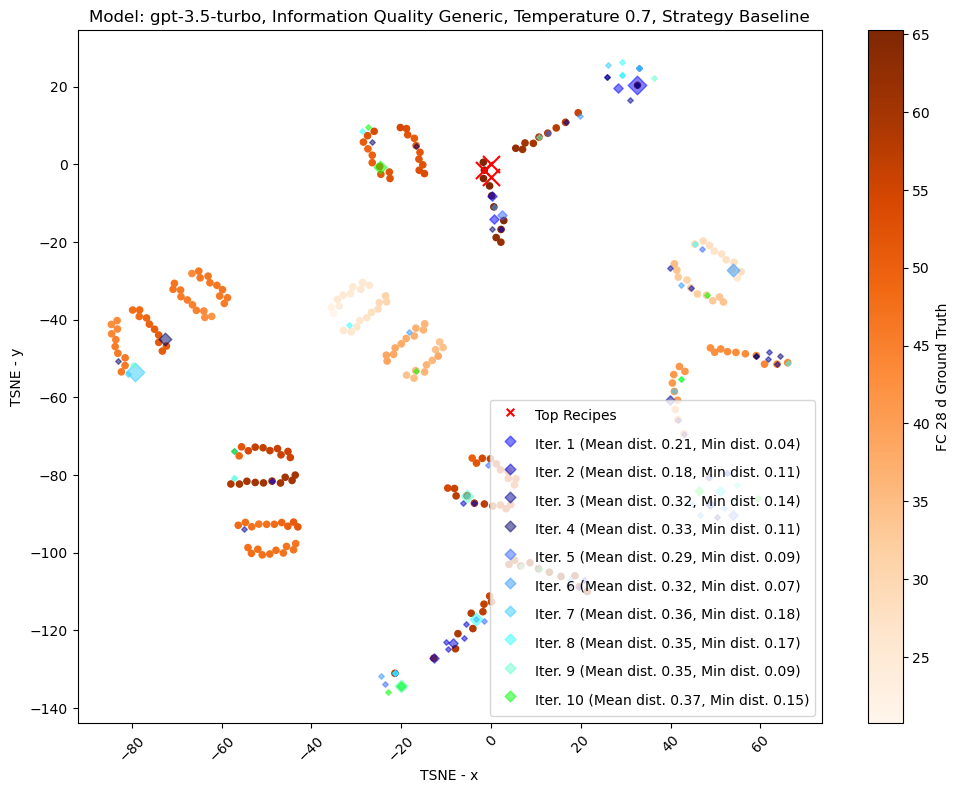

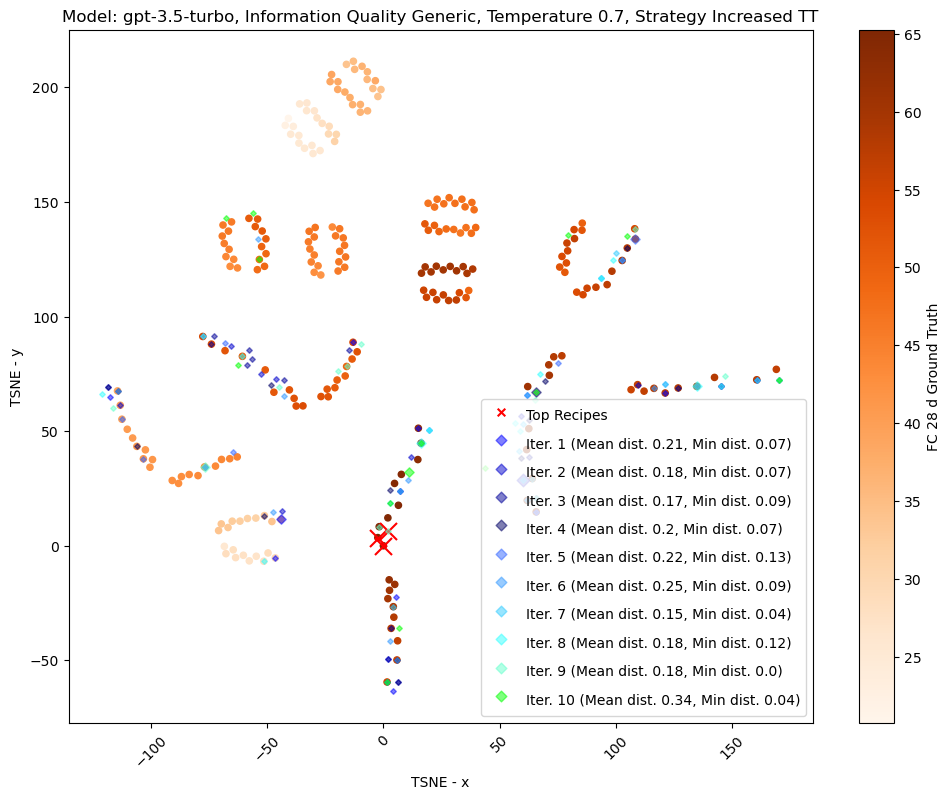

In [14]:
analyse_distribution(tsne_model=tsne_model, target_mode=False)

In [ ]:
analyse_distribution(tsne_model=tsne_model, target_mode=False, model='gpt-4-1106-preview')

### TSNE: Design space with FC 28d Color Indication

In [ ]:
# analyse_distribution(tsne_model=tsne_model, target_mode=True)

In [ ]:
from matplotlib import colormaps
list(colormaps)